Using device: cpu


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


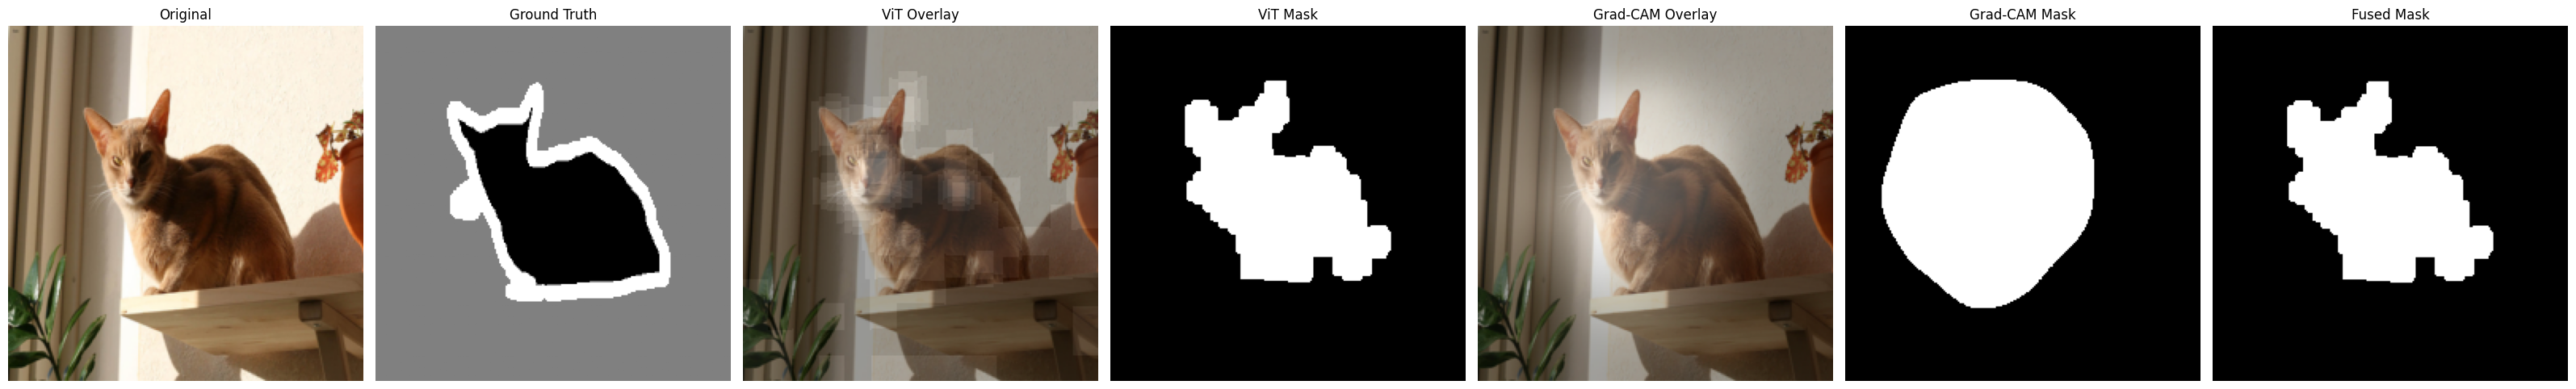


--- ViT Mask Metrics ---
TP=7039, FP=2581, FN=575
Precision=0.7317, Recall=0.9245
Dice/F1=0.8169, IoU=0.6904


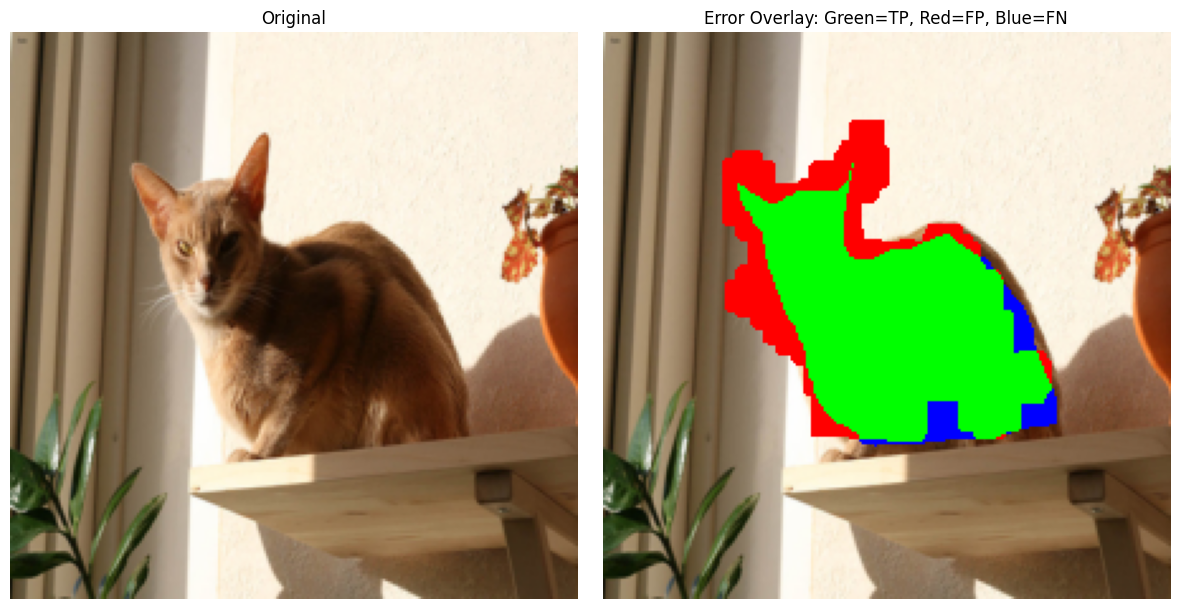


--- Grad-CAM Mask Metrics ---
TP=6031, FP=8852, FN=1583
Precision=0.4052, Recall=0.7921
Dice/F1=0.5362, IoU=0.3663


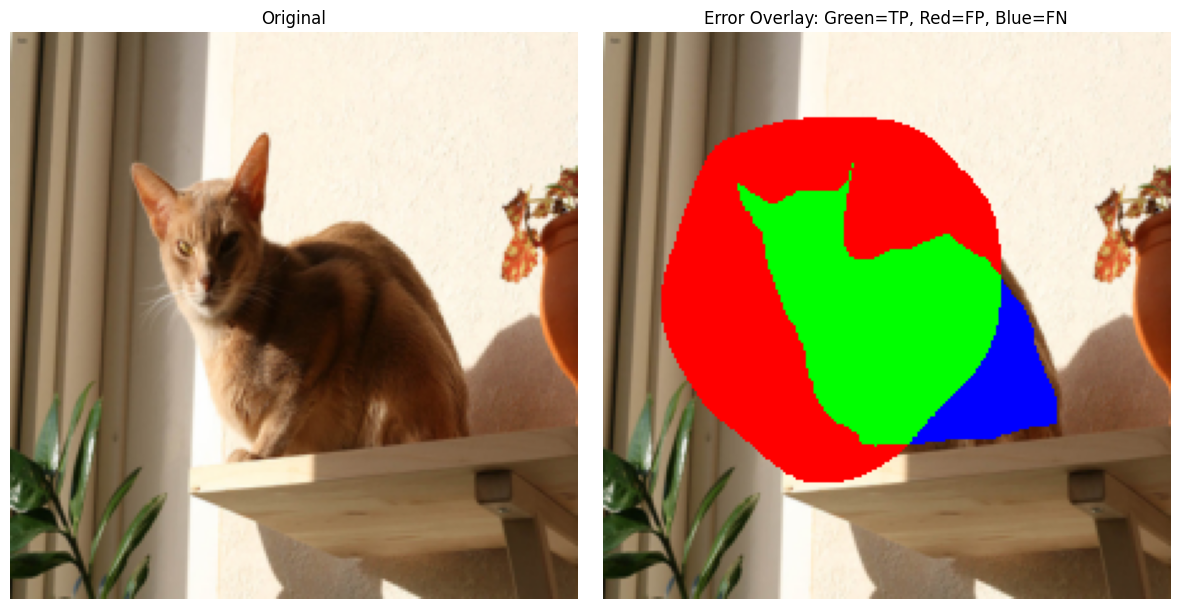


--- Fused Mask Metrics ---
TP=7039, FP=2581, FN=575
Precision=0.7317, Recall=0.9245
Dice/F1=0.8169, IoU=0.6904


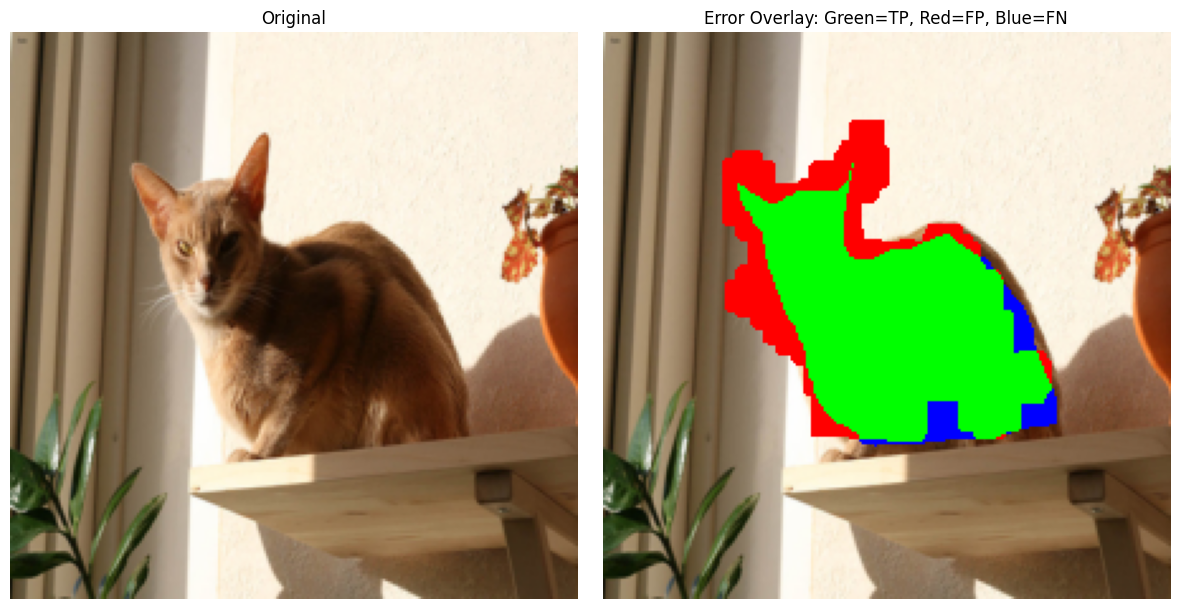

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms, models
from transformers import AutoModel, AutoImageProcessor
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

dataset = OxfordIIITPet(
    root='./data', split='trainval', target_types='segmentation',
    transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]),
    download=True
)

def otsu_threshold(image_array):
    pixel_counts = np.bincount(image_array.flatten(), minlength=256)
    total = image_array.size
    sum_total = np.dot(np.arange(256), pixel_counts)
    sum_bg, weight_bg, max_var, threshold = 0.0, 0.0, 0.0, 0
    for t in range(256):
        weight_bg += pixel_counts[t]
        if weight_bg == 0: continue
        weight_fg = total - weight_bg
        if weight_fg == 0: break
        sum_bg += t * pixel_counts[t]
        mean_bg = sum_bg / weight_bg
        mean_fg = (sum_total - sum_bg) / weight_fg
        var_between = weight_bg * weight_fg * (mean_bg - mean_fg) ** 2
        if var_between > max_var:
            max_var = var_between
            threshold = t
    return threshold / 255.0

def erode(mask, k=3):
    pad = k // 2
    padded = np.pad(mask, pad, mode='constant')
    out = np.zeros_like(mask)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            out[i, j] = np.min(padded[i:i+k, j:j+k])
    return out

def dilate(mask, k=3):
    pad = k // 2
    padded = np.pad(mask, pad, mode='constant')
    out = np.zeros_like(mask)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            out[i, j] = np.max(padded[i:i+k, j:j+k])
    return out

def open_then_close(mask):
    return dilate(erode(mask))

def keep_largest_component(mask):
    H, W = mask.shape
    visited = np.zeros_like(mask, dtype=bool)
    best_region, max_size = [], 0
    for i in range(H):
        for j in range(W):
            if mask[i, j] == 1 and not visited[i, j]:
                stack, region = [(i, j)], [(i, j)]
                visited[i, j] = True
                while stack:
                    x, y = stack.pop()
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < H and 0 <= ny < W and not visited[nx, ny] and mask[nx, ny] == 1:
                                visited[nx, ny] = True
                                stack.append((nx, ny))
                                region.append((nx, ny))
                if len(region) > max_size:
                    max_size = len(region)
                    best_region = region
    final_mask = np.zeros_like(mask)
    for x, y in best_region:
        final_mask[x, y] = 1
    return final_mask.astype(np.uint8)

def gaussian_blur(image, kernel_size=5, sigma=1.0):
    ax = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)
    pad = kernel_size // 2
    padded = np.pad(image, pad, mode='reflect')
    blurred = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+kernel_size, j:j+kernel_size]
            blurred[i, j] = np.sum(region * kernel)
    return blurred


dino_model = AutoModel.from_pretrained("facebook/dino-vits16", output_attentions=True).to(device).eval()
dino_processor = AutoImageProcessor.from_pretrained("facebook/dino-vits16")

def extract_vit_mask(img_pil, selected_layers=[1,3,5,7,9,11]):
    w, h = img_pil.size
    inputs = dino_processor(images=img_pil, return_tensors="pt").to(device)
    with torch.no_grad():
        attn = dino_model(**inputs).attentions
    attn_maps = [attn[i][0].mean(0)[0,1:] for i in selected_layers]
    cls_attn = (torch.stack(attn_maps).mean(0) + torch.stack(attn_maps).max(0).values) / 2
    side = int(cls_attn.shape[0] ** 0.5)
    attn_map = cls_attn.reshape(side, side).cpu().numpy()
    attn_map = np.array(Image.fromarray((attn_map * 255).astype(np.uint8)).resize((w,h))) / 255.0
    norm_attn = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-5)
    smoothed = gaussian_blur(norm_attn)
    t = max(0.12, otsu_threshold((smoothed * 255).astype(np.uint8)) * 0.75)
    binary_mask = (smoothed > t).astype(np.uint8)
    cleaned = keep_largest_component(open_then_close(binary_mask))
    return norm_attn, Image.fromarray(cleaned * 255).convert("L")


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations, self.gradients = None, None
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        class_idx = class_idx or output.argmax().item()
        output[:, class_idx].backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam_map = torch.relu((weights * self.activations).sum(1)).squeeze().cpu().numpy()
        return (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min() + 1e-6)

def extract_gradcam_mask(img_tensor):
    model = models.resnet50(pretrained=True).to(device)
    gradcam = GradCAM(model, model.layer4[-1])
    cam_map = gradcam(img_tensor.to(device))
    cam_map = np.array(Image.fromarray((cam_map * 255).astype(np.uint8)).resize((224,224))) / 255.0
    t = otsu_threshold((cam_map * 255).astype(np.uint8))
    binary_mask = (cam_map > t).astype(np.uint8)
    cleaned = keep_largest_component(open_then_close(binary_mask))
    return cam_map, Image.fromarray(cleaned * 255).convert("L")


def fuse_masks(vit_mask, grad_mask):
    vit = np.array(vit_mask).astype(np.float32) / 255
    grad = np.array(grad_mask).astype(np.float32) / 255
    fused = (0.7 * vit + 0.3 * grad)
    fused_bin = (fused > 0.45).astype(np.uint8)
    cleaned = keep_largest_component(open_then_close(fused_bin))
    return Image.fromarray(cleaned * 255).convert("L")


def overlay_attention(img_pil, attn_map):
    img = np.array(img_pil)
    heat = (attn_map * 255).astype(np.uint8)
    heat = np.stack([heat]*3, axis=-1)
    overlay = (0.6 * img + 0.4 * heat).astype(np.uint8)
    return Image.fromarray(overlay)

def show_comparison(img, gt_mask, vit_map, vit_mask, grad_map, grad_mask, fused_mask):
    fig, axs = plt.subplots(1, 7, figsize=(32, 5))
    titles = ["Original", "Ground Truth", "ViT Overlay", "ViT Mask", "Grad-CAM Overlay", "Grad-CAM Mask", "Fused Mask"]
    images = [img, gt_mask, overlay_attention(img, vit_map), vit_mask, overlay_attention(img, grad_map), grad_mask, fused_mask]
    for ax, title, im in zip(axs, titles, images):
        ax.imshow(im, cmap='gray' if im.mode == 'L' else None)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout(); plt.show()

def detailed_metrics(pred_mask, gt_mask, verbose=True):
    pred = (np.array(pred_mask) > 128).astype(np.uint8)
    gt_np = np.array(gt_mask)

    gt_bin = (gt_np == 1).astype(np.uint8)

    tp = np.logical_and(pred == 1, gt_bin == 1).sum()
    fp = np.logical_and(pred == 1, gt_bin == 0).sum()
    fn = np.logical_and(pred == 0, gt_bin == 1).sum()

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    iou = tp / (tp + fp + fn + 1e-6)

    if verbose:
        print(f"TP={tp}, FP={fp}, FN={fn}")
        print(f"Precision={precision:.4f}, Recall={recall:.4f}")
        print(f"Dice/F1={f1:.4f}, IoU={iou:.4f}")

    return {
        'TP': tp, 'FP': fp, 'FN': fn,
        'Precision': precision, 'Recall': recall,
        'Dice': f1, 'IoU': iou
    }

def visualize_fp_fn(img_pil, pred_mask, gt_mask):
    img = np.array(img_pil).copy()
    pred = (np.array(pred_mask) > 128).astype(np.uint8)
    gt_np = np.array(gt_mask)
    gt_bin = (gt_np == 1).astype(np.uint8)

    tp = np.logical_and(pred == 1, gt_bin == 1)
    fp = np.logical_and(pred == 1, gt_bin == 0)
    fn = np.logical_and(pred == 0, gt_bin == 1)

    overlay = img.copy()
    overlay[fp] = [255, 0, 0] 
    overlay[fn] = [0, 0, 255] 
    overlay[tp] = [0, 255, 0] 

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(img)
    axs[0].set_title("Original")
    axs[1].imshow(overlay)
    axs[1].set_title("Error Overlay: Green=TP, Red=FP, Blue=FN")
    for ax in axs: ax.axis("off")
    plt.tight_layout(); plt.show()


idx = 42 
img_tensor, mask_tensor = dataset[idx]
img_tensor_unsqueezed = img_tensor.unsqueeze(0)
img_pil = transforms.ToPILImage()(img_tensor)
gt_mask = mask_tensor.resize((224, 224)).convert("L")

vit_map, vit_mask = extract_vit_mask(img_pil)
grad_map, grad_mask = extract_gradcam_mask(img_tensor_unsqueezed)
fused_mask = fuse_masks(vit_mask, grad_mask)

show_comparison(img_pil, gt_mask, vit_map, vit_mask, grad_map, grad_mask, fused_mask)

print("\n--- ViT Mask Metrics ---")
detailed_metrics(vit_mask, gt_mask)
visualize_fp_fn(img_pil, vit_mask, gt_mask)

print("\n--- Grad-CAM Mask Metrics ---")
detailed_metrics(grad_mask, gt_mask)
visualize_fp_fn(img_pil, grad_mask, gt_mask)

print("\n--- Fused Mask Metrics ---")
detailed_metrics(fused_mask, gt_mask)
visualize_fp_fn(img_pil, fused_mask, gt_mask)


In [35]:
def evaluate_on_dataset(dataset, max_samples=None, verbose_every=50):
    vit_scores, grad_scores, fused_scores = [], [], []

    for idx in range(len(dataset)):
        if max_samples and idx >= max_samples:
            break

        img_tensor, mask_tensor = dataset[idx]
        img_tensor_unsqueezed = img_tensor.unsqueeze(0)
        img_pil = transforms.ToPILImage()(img_tensor)
        gt_mask = mask_tensor.resize((224, 224)).convert("L")

        try:
            vit_map, vit_mask = extract_vit_mask(img_pil)
            grad_map, grad_mask = extract_gradcam_mask(img_tensor_unsqueezed)
            fused_mask = fuse_masks(vit_mask, grad_mask)

            vit_metrics = detailed_metrics(vit_mask, gt_mask, verbose=False)
            grad_metrics = detailed_metrics(grad_mask, gt_mask, verbose=False)
            fused_metrics = detailed_metrics(fused_mask, gt_mask, verbose=False)

            vit_scores.append(vit_metrics)
            grad_scores.append(grad_metrics)
            fused_scores.append(fused_metrics)

            if (idx + 1) % verbose_every == 0:
                print(f"Processed {idx + 1} samples...")
        except Exception as e:
            print(f"Skipping sample {idx} due to error: {e}")

    def summarize(scores):
        return {
            "Dice": np.mean([s["Dice"] for s in scores]),
            "IoU": np.mean([s["IoU"] for s in scores]),
            "Precision": np.mean([s["Precision"] for s in scores]),
            "Recall": np.mean([s["Recall"] for s in scores])
        }

    vit_summary = summarize(vit_scores)
    grad_summary = summarize(grad_scores)
    fused_summary = summarize(fused_scores)

    print("\n=== Average Metrics on Dataset ===")
    print(f"{'Method':<10} | {'Dice':<6} | {'IoU':<6} | {'Prec':<6} | {'Recall':<6}")
    print("-" * 50)
    for name, summary in zip(["ViT", "Grad-CAM", "Fused"], [vit_summary, grad_summary, fused_summary]):
        print(f"{name:<10} | {summary['Dice']:.4f} | {summary['IoU']:.4f} | {summary['Precision']:.4f} | {summary['Recall']:.4f}")

evaluate_on_dataset(dataset, max_samples=None)


/opt/anaconda3/envs/comp0197-cw2-pt/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/comp0197-cw2-pt/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/envs/comp0197-cw2-pt/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_ho

Processed 50 samples...
Processed 100 samples...
Processed 150 samples...
Processed 200 samples...
Processed 250 samples...
Processed 300 samples...
Processed 350 samples...
Processed 400 samples...
Processed 450 samples...
Processed 500 samples...
Processed 550 samples...
Processed 600 samples...
Processed 650 samples...
Processed 700 samples...
Processed 750 samples...
Processed 800 samples...
Processed 850 samples...
Processed 900 samples...
Processed 950 samples...
Processed 1000 samples...
Processed 1050 samples...
Processed 1100 samples...
Processed 1150 samples...
Processed 1200 samples...
Processed 1250 samples...
Processed 1300 samples...
Processed 1350 samples...
Processed 1400 samples...
Processed 1450 samples...
Processed 1500 samples...
Processed 1550 samples...
Processed 1600 samples...
Processed 1650 samples...
Processed 1700 samples...
Processed 1750 samples...
Processed 1800 samples...
Processed 1850 samples...
Processed 1900 samples...
Processed 1950 samples...
Proces